<a href="https://colab.research.google.com/github/davo260/TecOpt-Project/blob/main/optproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/davo260/TecOpt-Project.git

Cloning into 'TecOpt-Project'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 22.15 KiB | 3.69 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [3]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 77.8 MB/s eta 0:00:00


# Librerias que se usaran

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pulp as pl


# Preparacion de los datos

In [10]:
FILE = r"/content/TecOpt-Project/historico.xlsx"
ruta_demanda = r"/content/TecOpt-Project/demanda_fija.xlsx"

# Energia fotovoltaica

/tmp/ipython-input-1781337613.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_10min = df.resample("10T").interpolate(method="time")


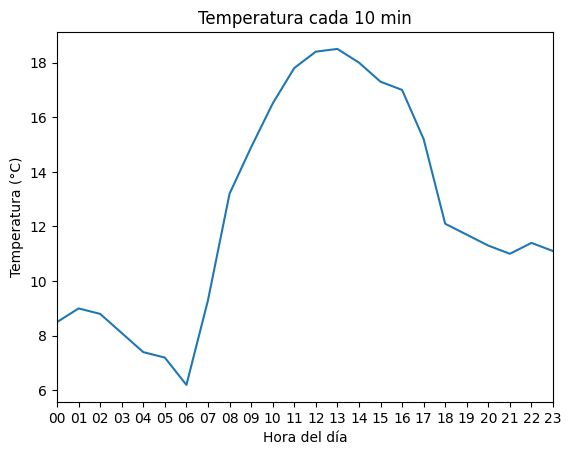

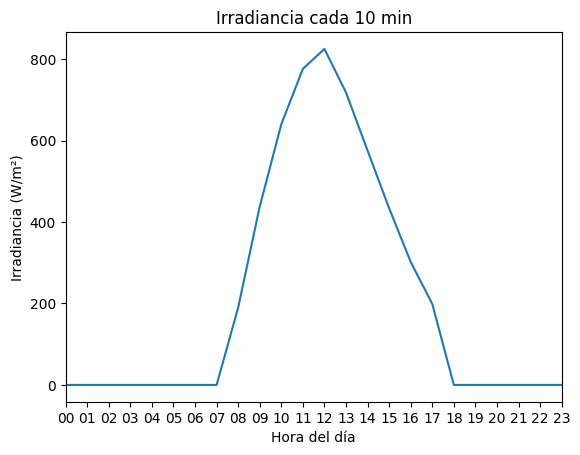

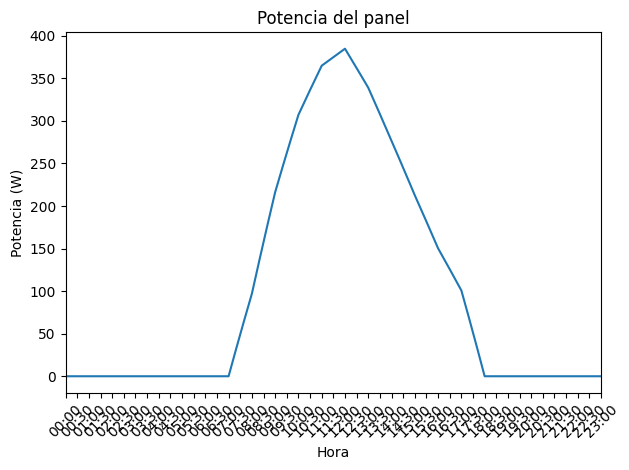

In [7]:
# 1. ENERGIA FOTOVOLTAICA
# === 1) CARGA DEL EXCEL ===
df = pd.read_excel(FILE, sheet_name=0, usecols="A:C", header=0)
df.columns = ["hora", "G_Wm2", "Ta_C"]

# Construir datetime (asumimos 1 de enero 2025)
df["datetime"] = pd.to_datetime("2025-01-01 " + df["hora"].astype(str))
df = df.set_index("datetime")[["G_Wm2", "Ta_C"]].sort_index()

# === 2) INTERPOLACIÓN A 10 MIN ===
df_10min = df.resample("10T").interpolate(method="time")

# === 3) FUNCIÓN AUXILIAR PARA FORMATO X ===
def format_eje_x_horas(ax):
    # ticks cada 1 hora
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    # formato solo hora (00, 01, 02, …, 23)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
    ax.set_xlim(df_10min.index.min(), df_10min.index.max())  # asegurar 00–23

# === 4) GRÁFICAS ===
# (a) Temperatura
fig, ax = plt.subplots()
ax.plot(df_10min.index, df_10min["Ta_C"])
ax.set_title("Temperatura cada 10 min")
ax.set_xlabel("Hora del día")
ax.set_ylabel("Temperatura (°C)")
format_eje_x_horas(ax)
plt.show()

# # (b) Irradiancia
fig, ax = plt.subplots()
ax.plot(df_10min.index, df_10min["G_Wm2"])
ax.set_title("Irradiancia cada 10 min")
ax.set_xlabel("Hora del día")
ax.set_ylabel("Irradiancia (W/m²)")
format_eje_x_horas(ax)
plt.show()

# ========= PARÁMETROS DEL PANEL =========
P_STC_W    = 500.0    # W, potencia nominal del panel a STC
G_STC      = 1000.0   # W/m^2 (STC) irradiancia de referencia STC (ecuacion)
Tcell_STC  = 25.0     # °C (STC) temperatura estandar de la celda solar (ecuacion)
NOCT_C     = 45.0     # °C ( NOCT real del panel)
gamma_perC = -0.0035  # 1/°C (coef. de temperatura de potencia: -0.35%/°C -> -0.0035)

# ========= 2) CÁLCULO FÍSICO =========
# Temperatura de celda (modelo NOCT): Tcel = Ta + ((NOCT-20)/800)*G
df_10min["Tcel_C"] = df_10min["Ta_C"] + ((NOCT_C - 20.0) / 800.0) * df_10min["G_Wm2"]

# Potencia del panel: P = Pstc * (G/Gstc) * [1 + gamma*(Tcel - Tcell_STC)]
G_ratio = (df_10min["G_Wm2"].clip(lower=0.0)) / G_STC
temp_factor = 1.0 + gamma_perC * (df_10min["Tcel_C"] - Tcell_STC)
df_10min["P_W"] = (P_STC_W * G_ratio * temp_factor).clip(lower=0.0)

# ========= 3) GRÁFICA: POTENCIA vs TIEMPO (ticks cada 30 min) =========
fig, ax = plt.subplots()
ax.plot(df_10min.index, df_10min["P_W"])
ax.set_title("Potencia del panel")
ax.set_xlabel("Hora")
ax.set_ylabel("Potencia (W)")

# # Ticks mayores cada 30 min y formato HH:MM
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# # # Limitar eje X exactamente al día de los datos
ax.set_xlim(df_10min.index.min(), df_10min.index.max())

# # girar etiquetas para que no se monten
plt.setp(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

df_10min["P_kW"] = df_10min["P_W"] / 1000.0

# Demanda a la red electrica

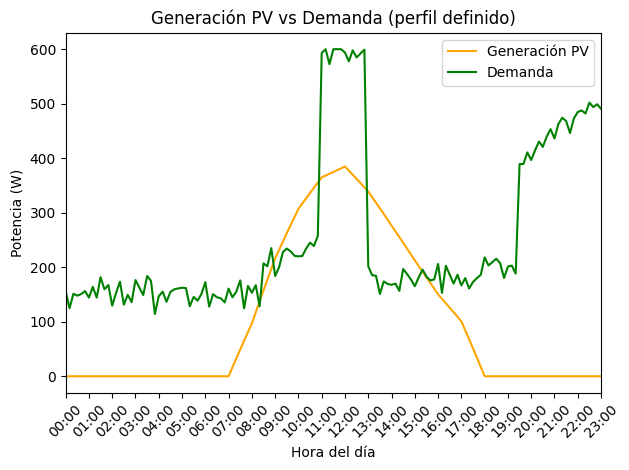

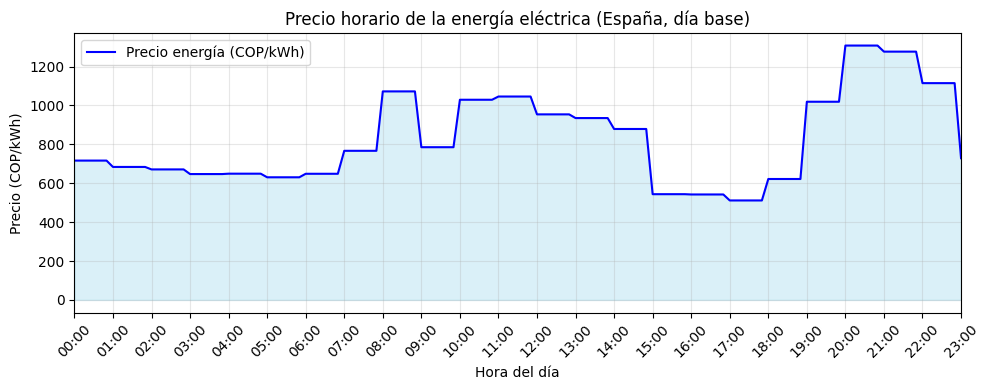

In [11]:
# 2. DEMANDA

# === LECTURA DE DEMANDA FIJA DESDE EXCEL ===
df_demanda = pd.read_excel(ruta_demanda, index_col=0, parse_dates=True)

# Verificar que los índices coincidan con df_10min
df_10min["Demanda_W"] = df_demanda["Demanda_W"].reindex(df_10min.index)

# === Graficar PV vs Demanda ===
fig, ax = plt.subplots()
ax.plot(df_10min.index, df_10min["P_W"], label="Generación PV", color="orange")
ax.plot(df_10min.index, df_10min["Demanda_W"], label="Demanda", color="green")
ax.set_title("Generación PV vs Demanda (perfil definido)")
ax.set_xlabel("Hora del día")
ax.set_ylabel("Potencia (W)")
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_xlim(df_10min.index.min(), df_10min.index.min() + pd.Timedelta(hours=23))
plt.setp(ax.get_xticklabels(), rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

# 3 PRECIOS DEMANDA

# === NUEVOS PRECIOS HORARIOS EN €/kWh ===
precios_eur_kWh = [
    0.1468,  # 00:00 - 01:00
    0.1401,  # 01:00 - 02:00
    0.1375,  # 02:00 - 03:00
    0.1326,  # 03:00 - 04:00
    0.1330,  # 04:00 - 05:00
    0.1292,  # 05:00 - 06:00
    0.1329,  # 06:00 - 07:00
    0.1571,  # 07:00 - 08:00
    0.2197,  # 08:00 - 09:00
    0.1609,  # 09:00 - 10:00
    0.2109,  # 10:00 - 11:00
    0.2143,  # 11:00 - 12:00
    0.1955,  # 12:00 - 13:00
    0.1916,  # 13:00 - 14:00
    0.1801,  # 14:00 - 15:00
    0.1114,  # 15:00 - 16:00
    0.1111,  # 16:00 - 17:00
    0.1048,  # 17:00 - 18:00
    0.1274,  # 18:00 - 19:00
    0.2088,  # 19:00 - 20:00
    0.2680,  # 20:00 - 21:00
    0.2616,  # 21:00 - 22:00
    0.2284,  # 22:00 - 23:00
    0.1493   # 23:00 - 24:00
]

# === CONVERSIÓN A COP/kWh ===
usd_to_cop = 4562        # 1 USD = 4562 COP
eur_to_usd = 1.07        # aprox tasa EUR → USD
factor = eur_to_usd * usd_to_cop               # EUR/kWh → COP/kWh

# Conversión directa
precios_cop = [p * factor for p in precios_eur_kWh]

# Expandir cada hora a 6 intervalos de 10 min
precios_cop_10min = np.repeat(precios_cop, 6)[:len(df_10min)]
df_10min["Precio_COP_kWh"] = precios_cop_10min

# === GRÁFICA DE PRECIOS ACTUALIZADA ===
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df_10min.index, df_10min["Precio_COP_kWh"], color="blue", label="Precio energía (COP/kWh)")
ax.fill_between(df_10min.index, df_10min["Precio_COP_kWh"], color="skyblue", alpha=0.3)
ax.set_title("Precio horario de la energía eléctrica (España, día base)")
ax.set_xlabel("Hora del día")
ax.set_ylabel("Precio (COP/kWh)")
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_xlim(df_10min.index.min(), df_10min.index.min() + pd.Timedelta(hours=23))
plt.setp(ax.get_xticklabels(), rotation=45)
ax.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Precios demanda a la red electrica

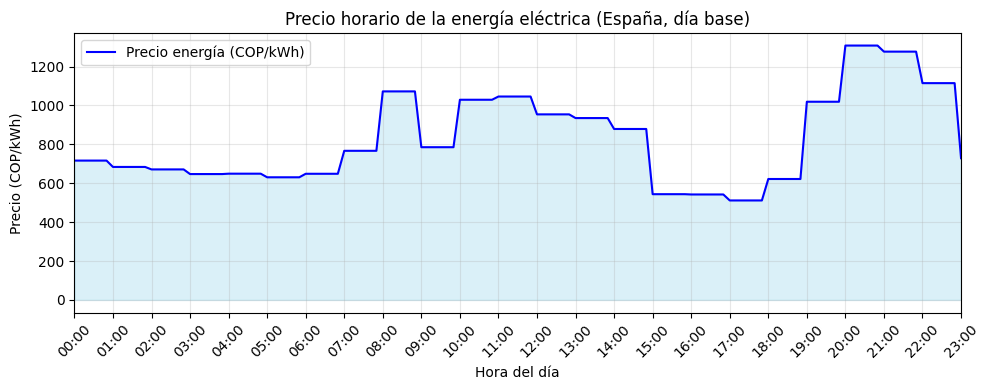

Precio promedio de compra: 827.77 COP/kWh
Precio promedio de venta : 579.44 COP/kWh


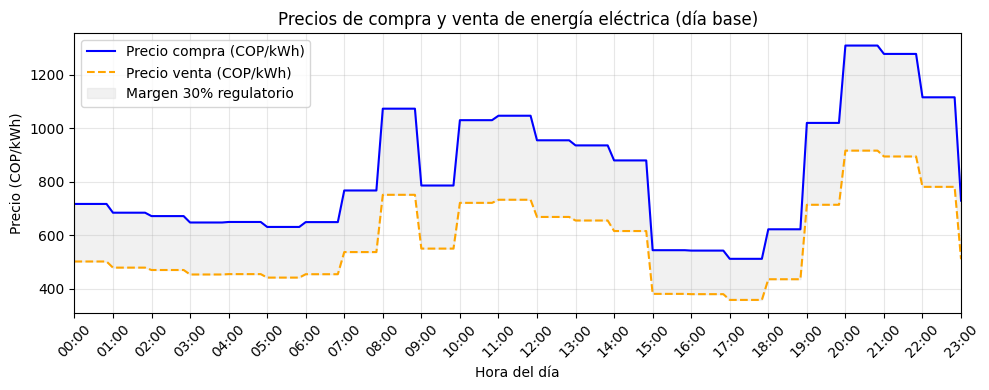

In [12]:

# === NUEVOS PRECIOS HORARIOS EN €/kWh ===
precios_eur_kWh = [
    0.1468,  # 00:00 - 01:00
    0.1401,  # 01:00 - 02:00
    0.1375,  # 02:00 - 03:00
    0.1326,  # 03:00 - 04:00
    0.1330,  # 04:00 - 05:00
    0.1292,  # 05:00 - 06:00
    0.1329,  # 06:00 - 07:00
    0.1571,  # 07:00 - 08:00
    0.2197,  # 08:00 - 09:00
    0.1609,  # 09:00 - 10:00
    0.2109,  # 10:00 - 11:00
    0.2143,  # 11:00 - 12:00
    0.1955,  # 12:00 - 13:00
    0.1916,  # 13:00 - 14:00
    0.1801,  # 14:00 - 15:00
    0.1114,  # 15:00 - 16:00
    0.1111,  # 16:00 - 17:00
    0.1048,  # 17:00 - 18:00
    0.1274,  # 18:00 - 19:00
    0.2088,  # 19:00 - 20:00
    0.2680,  # 20:00 - 21:00
    0.2616,  # 21:00 - 22:00
    0.2284,  # 22:00 - 23:00
    0.1493   # 23:00 - 24:00
]

# === CONVERSIÓN A COP/kWh ===
usd_to_cop = 4562        # 1 USD = 4562 COP
eur_to_usd = 1.07        # aprox tasa EUR → USD
factor = eur_to_usd * usd_to_cop               # EUR/kWh → COP/kWh

# Conversión directa
precios_cop = [p * factor for p in precios_eur_kWh]

# Expandir cada hora a 6 intervalos de 10 min
precios_cop_10min = np.repeat(precios_cop, 6)[:len(df_10min)]
df_10min["Precio_COP_kWh"] = precios_cop_10min

# === GRÁFICA DE PRECIOS ACTUALIZADA ===
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df_10min.index, df_10min["Precio_COP_kWh"], color="blue", label="Precio energía (COP/kWh)")
ax.fill_between(df_10min.index, df_10min["Precio_COP_kWh"], color="skyblue", alpha=0.3)
ax.set_title("Precio horario de la energía eléctrica (España, día base)")
ax.set_xlabel("Hora del día")
ax.set_ylabel("Precio (COP/kWh)")
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_xlim(df_10min.index.min(), df_10min.index.min() + pd.Timedelta(hours=23))
plt.setp(ax.get_xticklabels(), rotation=45)
ax.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()




# === PRECIO DE VENTA DE ENERGÍA A LA RED ===
# se vende al 70% del precio de compra

df_10min["Precio_venta_COP_kWh"] = 0.7 * df_10min["Precio_COP_kWh"]

# --- Verificación de valores ---
print("Precio promedio de compra:", round(df_10min["Precio_COP_kWh"].mean(), 2), "COP/kWh")
print("Precio promedio de venta :", round(df_10min["Precio_venta_COP_kWh"].mean(), 2), "COP/kWh")

# === GRÁFICA DE COMPRA vs VENTA ===
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df_10min.index, df_10min["Precio_COP_kWh"], label="Precio compra (COP/kWh)", color="blue")
ax.plot(df_10min.index, df_10min["Precio_venta_COP_kWh"], label="Precio venta (COP/kWh)", color="orange", linestyle="--")
ax.fill_between(df_10min.index, df_10min["Precio_COP_kWh"], df_10min["Precio_venta_COP_kWh"],
                color="lightgray", alpha=0.3, label="Margen 30% regulatorio")
ax.set_title("Precios de compra y venta de energía eléctrica (día base)")
ax.set_xlabel("Hora del día")
ax.set_ylabel("Precio (COP/kWh)")
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_xlim(df_10min.index.min(), df_10min.index.min() + pd.Timedelta(hours=23))
plt.setp(ax.get_xticklabels(), rotation=45)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# **Optimizacion EMS**

In [13]:
# === 1. PARÁMETROS GENERALES ===========================================
idx = df_10min.index
T = len(df_10min)
K = range(T)

dt_h = 10.0 / 60.0   # 10 minutos en horas
P_pv = df_10min["P_W"].to_numpy()
P_load = df_10min["Demanda_W"].to_numpy()
C_buy = df_10min["Precio_COP_kWh"].to_numpy()
C_sell = df_10min["Precio_venta_COP_kWh"].to_numpy()
C_batt = 400.0

# --- Batería ---
V_nom, I_nom, n_series = 12.0, 17.0, 3                       #estos son parametros?
Q_Wh = V_nom * I_nom * n_series     # 36 * 17 = 612 Wh       #estos son parametros? o mas bien dejo solo el Q porque como si se el valor
SOC_min, SOC_max, SOC0 = 0.20, 1.0, 1.0
eta_c, eta_d = 0.92, 0.95
Pch_ref, Pdc_ref = 162.0, 315.0             #Carga 13.5V * 4 A * 3  #Descarga: 10.5 * 10 * 3
M = 9999
alpha = beta = 1.0
DeltaSOC = SOC_max - SOC_min                              # esto es parametro?


# -----------------------------------------------------------------------
# === 3. MODELO DE OPTIMIZACIÓN ========================================
m = pl.LpProblem("EMS_SOC_dependiente", pl.LpMinimize)

# Variables
p_grid_imp = pl.LpVariable.dicts("p_grid_imp", K, lowBound=0)
p_grid_exp = pl.LpVariable.dicts("p_grid_exp", K, lowBound=0)
p_batt_c = pl.LpVariable.dicts("p_batt_c", K, lowBound=0)
p_batt_d = pl.LpVariable.dicts("p_batt_d", K, lowBound=0)
SOC = pl.LpVariable.dicts("SOC", range(T+1))
z_grid = pl.LpVariable.dicts("z_grid", K, 0, 1, cat="Binary")
z_batt = pl.LpVariable.dicts("z_batt", K, 0, 1, cat="Binary")

# Objetivo
m += pl.lpSum([
    (C_buy[k] * p_grid_imp[k] * dt_h / 1000.0)
    - (C_sell[k] * p_grid_exp[k] * dt_h / 1000.0)
    + (C_batt * (p_batt_c[k] + p_batt_d[k]) * dt_h / 1000.0)
    for k in K
])

# SOC inicial fijo
m += SOC[0] == SOC0

# -----------------------------------------------------------------------
# === 4. RESTRICCIONES ==================================================
for k in K:
    # (1) Balance de potencia
    m += (
        P_pv[k] + p_grid_imp[k] + p_batt_d[k]
        == P_load[k] + p_grid_exp[k] + p_batt_c[k]
    ), f"bal_{k}"

    # (2) Dinámica del SOC
    m += SOC[k+1] == SOC[k] \
        + (eta_c * p_batt_c[k] * dt_h / Q_Wh) \
        - (p_batt_d[k] * dt_h / (eta_d * Q_Wh)), f"soc_dyn_{k}"

    # (3) Límites SOC
    m += SOC[k] >= SOC_min, f"soc_min_{k}"
    m += SOC[k] <= SOC_max, f"soc_max_{k}"
    m += SOC[k+1] >= SOC_min, f"soc_min_next_{k}"
    m += SOC[k+1] <= SOC_max, f"soc_max_next_{k}"

    # (4) Exclusividad batería
    m += p_batt_c[k] <= M * z_batt[k]
    m += p_batt_d[k] <= M * (1 - z_batt[k])

    # (5) Exclusividad red
    m += p_grid_imp[k] <= M * z_grid[k]
    m += p_grid_exp[k] <= M * (1 - z_grid[k])

     # (6) potencias
    m += p_batt_c[k] <= Pch_ref * (1 - ((SOC[k] - SOC_min)/DeltaSOC)), f"pch_soc_{k}"
    m += p_batt_d[k] <= Pdc_ref * (1 - ((SOC_max - SOC[k])/DeltaSOC)), f"pdc_soc_{k}"


# -----------------------------------------------------------------------
# === 5. SOLUCIÓN =======================================================
status = m.solve(pl.PULP_CBC_CMD(msg=False))
print("Estado:", pl.LpStatus[status])                             #para comprobar que si esta funcionando

# Resultados
p_imp_v = np.array([pl.value(p_grid_imp[k]) for k in K])
p_exp_v = np.array([pl.value(p_grid_exp[k]) for k in K])
p_c_v = np.array([pl.value(p_batt_c[k]) for k in K])
p_d_v = np.array([pl.value(p_batt_d[k]) for k in K])
SOC_v = np.array([pl.value(SOC[k]) for k in range(T+1)])

print(f"SOC_ini={SOC_v[0]:.3f}, SOC_fin={SOC_v[-1]:.3f}")           #para verificar que se cumplio la restriccion
print(f"SOC_min={SOC_v.min():.3f}, SOC_max={SOC_v.max():.3f}")      #para verificar que se cumplio la restriccion


Estado: Optimal
SOC_ini=1.000, SOC_fin=0.282
SOC_min=0.282, SOC_max=1.000


# **Graficacion a la solución**

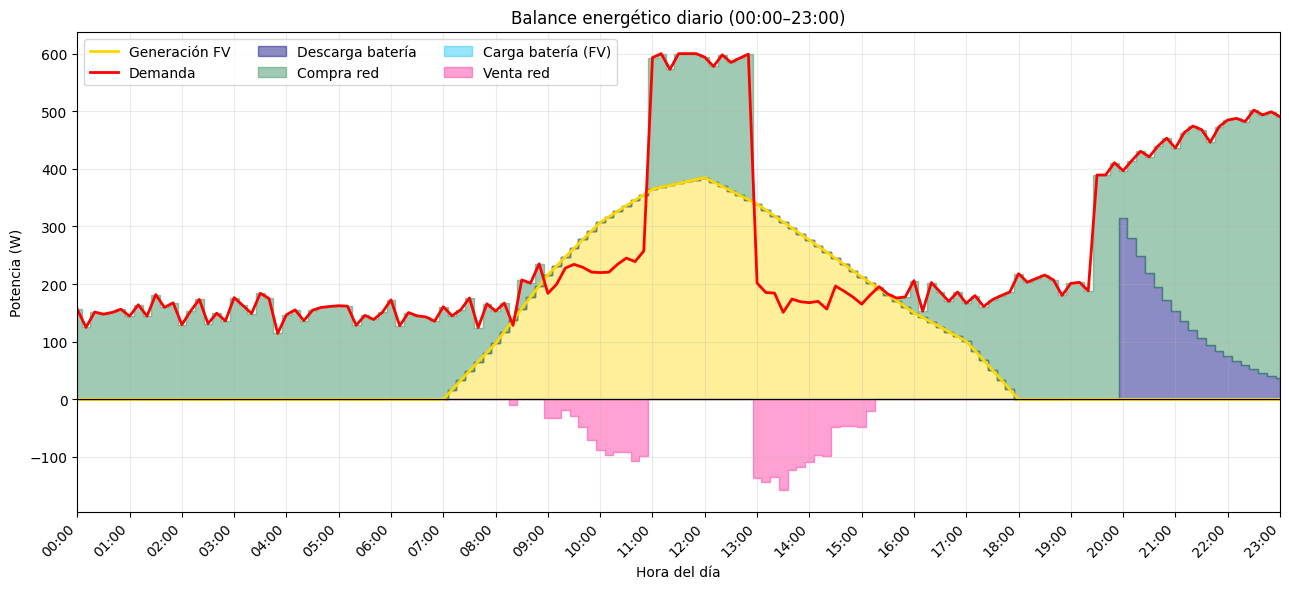

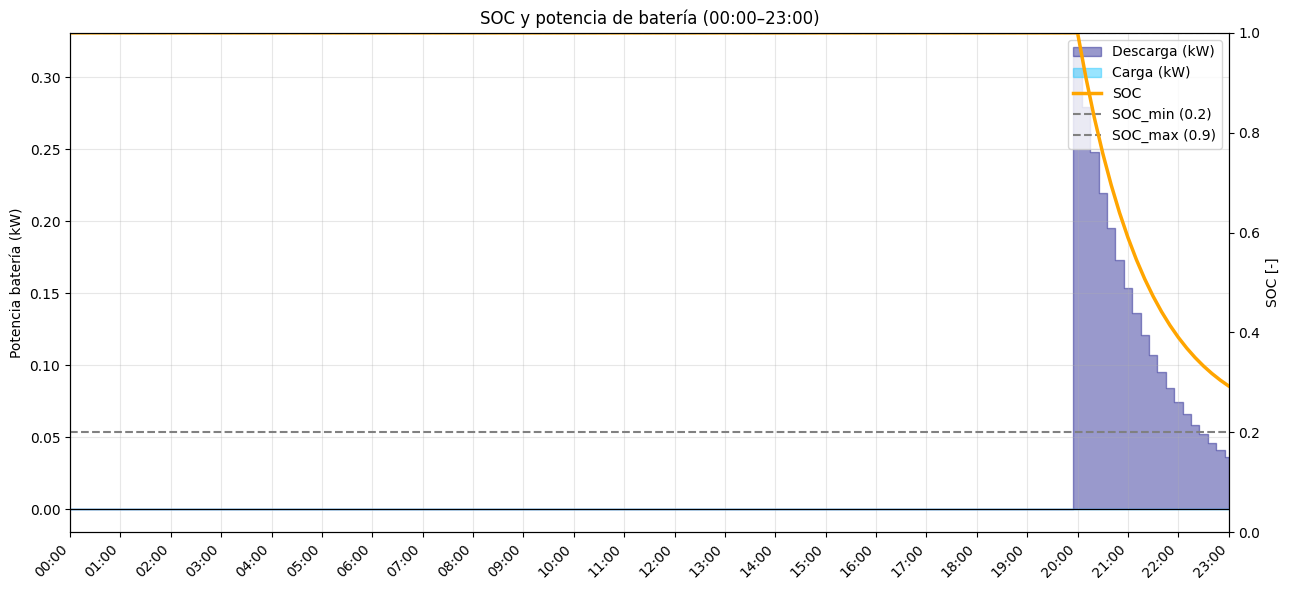

In [14]:

# Configuración de rango horario
hora_inicio = df_10min.index.min().replace(hour=0, minute=0)
hora_fin = hora_inicio + pd.Timedelta(hours=23)

# === GRÁFICA 1 — Balance energético general ===
fig, ax = plt.subplots(figsize=(13, 6))

# Generación FV (línea + área)
ax.plot(idx, P_pv, color="gold", lw=2, label="Generación FV")
ax.fill_between(idx, 0, P_pv, color="gold", alpha=0.4)

# Demanda (línea)
ax.plot(idx, P_load, color="red", lw=2, label="Demanda")

# Apilar: descarga batería sobre FV
top = P_pv.copy()
ax.fill_between(idx, top, top + p_d_v, step="mid",
                color="navy", alpha=0.45, label="Descarga batería")

# Compra red (encima de todo)
top += p_d_v
ax.fill_between(idx, top, top + p_imp_v, step="mid",
                color="seagreen", alpha=0.45, label="Compra red")

# Áreas debajo del eje
ax.fill_between(idx, 0, -p_c_v, step="mid",
                color="deepskyblue", alpha=0.4, label="Carga batería (FV)")
ax.fill_between(idx, 0, -p_exp_v, step="mid",
                color="deeppink", alpha=0.4, label="Venta red")

# Ejes y formato
ax.axhline(0, color="k", lw=0.8)
ax.set_ylabel("Potencia (W)")
ax.set_xlabel("Hora del día")
ax.set_title("Balance energético diario (00:00–23:00)")

# --- EJE X ---
ax.set_xlim(hora_inicio, hora_fin)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Leyenda y estilo
ax.legend(ncol=3, loc="upper left")
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# === GRÁFICA 2 — SOC y Potencia de la batería ===
fig, ax1 = plt.subplots(figsize=(13, 6))

# Potencias
ax1.fill_between(idx, 0, p_d_v / 1000.0, step="mid",
                 color="navy", alpha=0.4, label="Descarga (kW)")
ax1.fill_between(idx, 0, -p_c_v / 1000.0, step="mid",
                 color="deepskyblue", alpha=0.4, label="Carga (kW)")
ax1.axhline(0, color="k", lw=0.8)
ax1.set_ylabel("Potencia batería (kW)")

# --- EJE X ---
ax1.set_xlim(hora_inicio, hora_fin)
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

# SOC
idx_plus = idx.append(idx[-1:] + (idx[-1] - idx[-2]))
ax2 = ax1.twinx()
ax2.plot(idx_plus, SOC_v, color="orange", lw=2.5, label="SOC")
ax2.axhline(SOC_min, ls="--", color="gray", label="SOC_min (0.2)")
ax2.axhline(SOC_max, ls="--", color="gray", label="SOC_max (0.9)")
ax2.set_ylim(0, 1)
ax2.set_ylabel("SOC [-]")

# Leyenda combinada
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper right")

ax1.set_title("SOC y potencia de batería (00:00–23:00)")
ax1.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Costo de uso de la batería: 200.0 COP/kWh


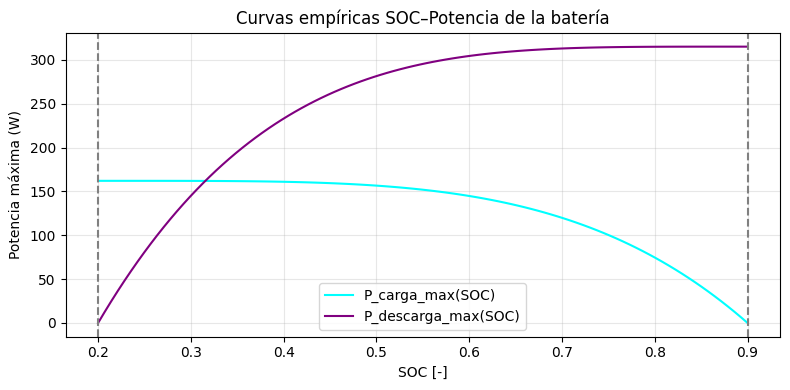

In [15]:
#8) comprobar comportamiento de la potencia de la bateria                   #PUEDO OMITIR TODO ESTE NUMERAL 8? YA QUE SOLO ESTOY COMPROBANTE QUE EL COMPORTAMIENTO ESTE BIEN

# --- Parámetros del banco (3S1P, 36 V nominal) ---
C_nom_Ah = 17.0          # Capacidad nominal de UNA batería [Ah]
n_series = 3             # Número de baterías en serie
V_nom = 12.0 * n_series  # Voltaje nominal ≈ 36 V
C_bank_Ah = C_nom_Ah     # Como es 1P, la capacidad no cambia

# Capacidad nominal total en Wh (energía útil total del banco)
Cap_Wh = V_nom * C_bank_Ah   # 36 V * 17 Ah = 612 Wh

# Tensiones de operación (según datasheet CSB GP12170)
V_chg = 13.5 * n_series   # Voltaje de carga (≈ 40.5 V)
V_dis = 10.5 * n_series   # Voltaje de descarga (≈ 31.5 V)

# Corrientes máximas (del datasheet)
I_chg_max = 4.0    # Corriente máxima de carga [A]
I_dis_max = 10.0   # Corriente máxima de descarga [A]

# Ventana de operación del SOC
SOC_min = 0.20   # Mínimo permitido (20 %)
SOC_max = 0.90   # Máximo permitido (90 %)
SOC0 = 1.0       # SOC inicial (100 %)

# Eficiencias de carga y descarga
eta_chg = 0.92
eta_dis = 0.95

# --- Costo de uso nivelado (fijo) ---
c_batt_COP_kWh = 200.0   # COP/kWh (costo de throughput)
print("Costo de uso de la batería:", c_batt_COP_kWh, "COP/kWh")

# --- Potencias máximas de referencia ---
Pch_ref = V_chg * I_chg_max   # Potencia máxima de carga [W]
Pdc_ref = V_dis * I_dis_max   # Potencia máxima de descarga [W]

# --- Parámetros empíricos de la curva SOC–Potencia ---
alpha = 4.0   # Carga: caída suave al acercarse a SOC_max
beta  = 4.0   # Descarga: caída suave al acercarse a SOC_min
DeltaSOC = SOC_max - SOC_min

# --- Funciones auxiliares ---

def Pch_max(SOC):
    """
    Potencia máxima de carga [W] según el estado de carga (SOC).
    Disminuye exponencialmente conforme el SOC se acerca al límite superior.
    """
    x = np.clip((SOC - SOC_min) / DeltaSOC, 0.0, 1.0)
    return Pch_ref * (1.0 - x**alpha)

def Pdc_max(SOC):
    """
    Potencia máxima de descarga [W] según el estado de carga (SOC).
    Disminuye exponencialmente conforme el SOC se acerca al límite inferior.
    """
    y = np.clip((SOC_max - SOC) / DeltaSOC, 0.0, 1.0)
    return Pdc_ref * (1.0 - y**beta)

def update_soc_p(P_chg, P_dis, soc, dt_h):
    """
    Actualiza el estado de carga (SOC) usando potencia de carga/descarga [W].
    Ecuación:
        SOC(k+1) = SOC(k)
                    - (P_dis * dt) / (η_dis * Cap_Wh)
                    + (P_chg * dt) / (η_chg * Cap_Wh)
    """
    d_soc = -(P_dis * dt_h) / (eta_dis * Cap_Wh) \
            + (P_chg * dt_h) / (eta_chg * Cap_Wh)
    soc_new = min(max(soc + d_soc, SOC_min), SOC_max)
    return soc_new


# --- Verificación gráfica de la curva SOC–Potencia ---
soc_vec = np.linspace(SOC_min, SOC_max, 100)
plt.figure(figsize=(8,4))
plt.plot(soc_vec, Pch_max(soc_vec), label="P_carga_max(SOC)", color='cyan')
plt.plot(soc_vec, Pdc_max(soc_vec), label="P_descarga_max(SOC)", color='purple')
plt.axvline(SOC_min, ls='--', color='gray')
plt.axvline(SOC_max, ls='--', color='gray')
plt.xlabel("SOC [-]")
plt.ylabel("Potencia máxima (W)")
plt.title("Curvas empíricas SOC–Potencia de la batería")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
